<a href="https://colab.research.google.com/github/kk0mtl/computer-vision/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
mnist_train=dset.MNIST("/content/drive/MyDrive/mnist", train=True, transform=transforms.ToTensor(),
                       target_transform=None, download=True)
mnist_test=dset.MNIST("/content/drive/MyDrive/mnist", train=False, transform=transforms.ToTensor(),
                       target_transform=None, download=True)

mnist_train 길이 :  60000
mnist_test 길이 :  10000
image data 형태 :  torch.Size([1, 28, 28])
label :  5


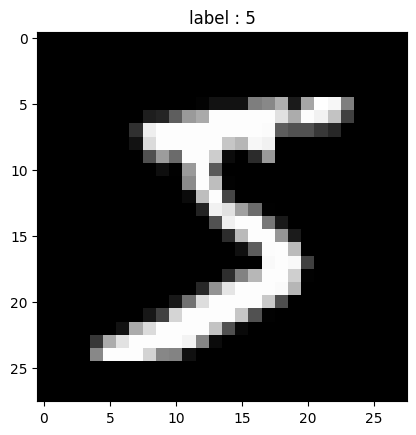

In [18]:
print("mnist_train 길이 : ", len(mnist_train))
print("mnist_test 길이 : ", len(mnist_test))

image,label = mnist_train.__getitem__(0)
print("image data 형태 : ", image.size())
print("label : ", label)

img = image.numpy()
plt.title("label : %d" % label)
plt.imshow(img[0], cmap='gray')
plt.show()

5
torch.Size([1, 28, 28])
5


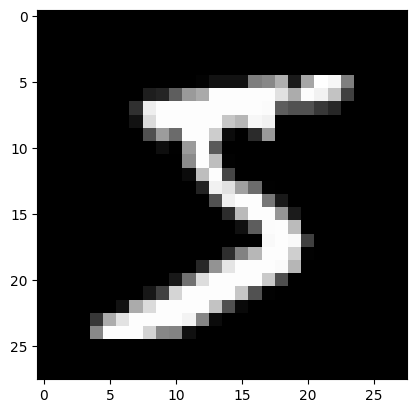

0


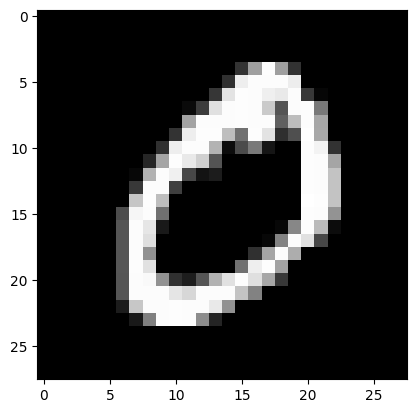

4


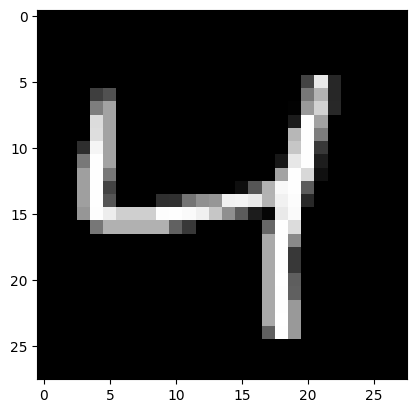

In [ ]:
print(mnist_train[0][1])  # 첫번째 데이터의 label
print(mnist_train[0][0].size())  # 첫번째 데이터의 image shape

for i in range(3):
  img=mnist_train[i][0].numpy()
  print(mnist_train[i][1])
  plt.imshow(img[0], cmap='gray')
  plt.show()

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


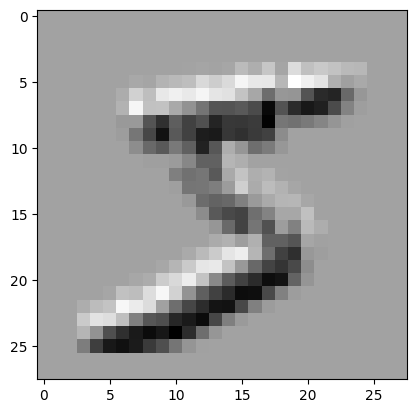

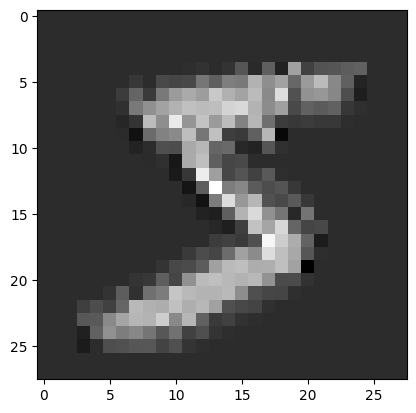

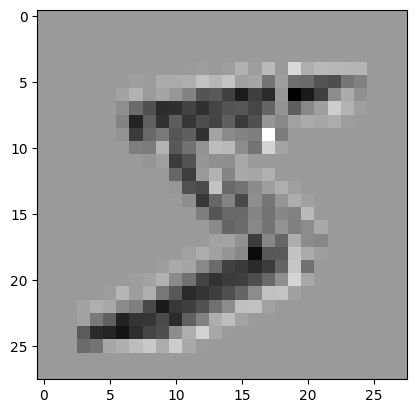

In [20]:
image, label = mnist_train[0]

# -1 : 차원 확장
# [1, 28, 28] -> [1, 1, 28, 28]
# image=image.reshape(-1, image.size()[0], image.size()[1], image.size()[2])
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

# filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
# filter 적용
output = conv_layer(Variable(image))
print(output.size())  # channel만 변경

for i in range(3):
  plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')  # 채널별로 출력
  plt.show()

In [39]:
import numpy as np
import torch.optim as optim

batch_size=15
learning_rate=0.0002
num_epoch=5

In [ ]:
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,
                                           shuffle=True, num_workers=2,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(list(mnist_test)[:batch_size*100], batch_size=batch_size,
                                           shuffle=False, num_workers=2,
                                           drop_last=True)

In [33]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()   # 28 x 28
    self.layer=nn.Sequential(
        nn.Conv2d(1, 16, 5, padding=2),
        nn.ReLU(),

        nn.Conv2d(16, 32, 5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),  # 28 x 28 => 14 x 14

        nn.Conv2d(32, 64, 5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2,2)   # 14 x 14 => 7 x 7
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*7*7, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)  # (batch_size, 64*7*7)
    out = self.fc_layer(out)
    return out

model = CNN().cuda()

In [ ]:
# param shape
for param in model.parameters():
  print(param)
  print(param.shape)

Parameter containing:
tensor([[[[-1.9323e-01, -1.7839e-02, -1.1759e-01,  6.4730e-02, -2.8586e-04],
          [-6.7643e-02, -7.9252e-02, -1.6304e-01, -4.8973e-02, -1.9931e-01],
          [ 1.7239e-01, -1.7614e-01, -1.9294e-01, -1.6546e-01, -1.8759e-01],
          [-1.9407e-01, -1.7430e-01, -1.6254e-01, -1.0859e-01, -4.8839e-02],
          [ 9.1282e-02,  1.9796e-01,  1.1913e-01,  7.2241e-02,  5.2716e-02]]],


        [[[ 1.6848e-01,  1.5627e-02,  1.4011e-01,  1.5047e-01, -6.5495e-02],
          [-1.2130e-01, -1.8862e-02, -5.4774e-02, -3.9491e-02, -1.4042e-01],
          [-6.0498e-02,  1.6852e-01, -1.6668e-01, -7.1427e-02,  1.5163e-01],
          [ 3.3914e-02,  1.3560e-01,  1.7263e-01,  1.3513e-01,  1.2919e-01],
          [-3.5924e-02,  9.8563e-02,  7.4295e-02,  1.7307e-01,  3.6338e-02]]],


        [[[-6.2410e-03, -1.9168e-01,  1.8800e-01,  4.5313e-02, -8.6548e-02],
          [-6.9888e-02, -6.4978e-02,  1.6522e-01,  6.1656e-02, -1.4356e-01],
          [-1.0833e-01, -1.9076e-01,  1.4123e-

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x = Variable(image).cuda()
    y_ = Variable(label).cuda()

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y_)
    loss.backward() # gradient 계산
    optimizer.step() # param 업데이트

    if j%50 ==0:
      print(loss, j, i)

tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>) 0 0
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>) 50 0
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>) 0 1
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>) 50 1
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>) 0 2
tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward0>) 50 2
tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>) 0 3
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>) 50 3
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>) 0 4
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>) 50 4


In [35]:
torch.save(model, '/content/drive/MyDrive/합성곱_신경망_실습/nets/mycnn_model_%d.pkl' %(num_epoch))

In [40]:
try:
  model=torch.load('/content/drive/MyDrive/합성곱_신경망_실습/nets/mycnn_model_5.pkl')
  print('model restored')
except:
  print('model not restored')

model restored


In [42]:
def ComputeAccur(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader):
    img = Variable(imgs).cuda()
    label = Variable(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data : {}".format(100*correct/total))

In [43]:
ComputeAccur(test_loader, model)

Accuracy of Test Data : 94.79999542236328
